In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install tensorboard_logger

!cp "/content/drive/MyDrive/DCC Codes/config.py" .
!cp "/content/drive/MyDrive/DCC Codes/edgeConstruction.py" .
!cp "/content/drive/MyDrive/DCC Codes/data_params.py" .
!cp "/content/drive/MyDrive/DCC Codes/make_data.py" .
!cp "/content/drive/MyDrive/DCC Codes/pretraining.py" .
!cp "/content/drive/MyDrive/DCC Codes/extract_feature.py" .
!cp "/content/drive/MyDrive/DCC Codes/copyGraph.py" .
!cp "/content/drive/MyDrive/DCC Codes/DCC.py" .
!cp "/content/drive/MyDrive/DCC Codes/extractSDAE.py" .
!cp "/content/drive/MyDrive/DCC Codes/extractconvSDAE.py" .
!cp "/content/drive/MyDrive/DCC Codes/SDAE.py" .
!cp "/content/drive/MyDrive/DCC Codes/__init__.py" .
!cp "/content/drive/MyDrive/DCC Codes/DCCComputation.py" .
!cp "/content/drive/MyDrive/DCC Codes/DCCLoss.py" .
!cp "/content/drive/MyDrive/DCC Codes/custom_data.py" .
!cp "/content/drive/MyDrive/DCC Codes/convSDAE.py" .

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn import preprocessing
from scipy.io import savemat
import scipy.io
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from config import cfg, get_data_dir
from easydict import EasyDict as edict
from edgeConstruction import compressed_data
from custom_data import DCCPT_data
import data_params as dp
import make_data
import pretraining
import extract_feature
import copyGraph
import DCC

In [ ]:
#some necessary initial functions

def set_pretraining_hypers(args):
  args.db = dp.oyster.name
  args.niter = 500
  args.step = 300
  args.lr = 0.001

# if we need to resume for faster debugging/results
  args.resume = False
  args.level = None

  args.batchsize = 300
  args.ngpu = 0
  args.deviceID = 0
  args.tensorboard = True
  args.h5 = False
  args.id = 2
  args.dim = 10
  args.manualSeed = cfg.RNG_SEED
  args.clean_log = True

def cluster_count(clusters):
  cluster_df = pd.DataFrame(clusters.T, columns= ['labels'])
  cluster_df_count = pd.DataFrame(np.array(cluster_df['labels'].value_counts()), columns= ['labels'])
  df_filtered = cluster_df_count[cluster_df_count['labels'] >= 100]
  return len(df_filtered)

def set_training_hypers(args):
  args.batchsize = cfg.PAIRS_PER_BATCH
  args.nepoch = 150
  args.M = 10
  args.lr = 0.001

#function for finding the most frequent element in a list
def most_frequent(List):
  return max(set(List), key = List.count)

#function for deleting certain key/value pairs in a dict and returning the poped keys
def delete_dict_items(dict, val):
  poped_keys = []
  for key, value in dict.copy().items():
    if value != val:
      poped_keys.append(key)
      dict.pop(key)

  return dict, poped_keys

#function for finding the minimum value and its corresponding key in a dict
def min_value(dict):
  min_value = min(dict.values())
  for key in dict:
    if dict[key] == min_value:
      min_value_key = key
  return min_value, min_value_key


def cluster_metrics(labels, features):

    numeval = len(labels)
    dbl = metrics.davies_bouldin_score(features, labels[:numeval])
    sil = metrics.silhouette_score(features, labels[:numeval], metric='euclidean')
    ch = metrics.calinski_harabasz_score(features, labels[:numeval])

    return dbl,sil,ch

In [ ]:
def change_time(start_number):
  mat_train = scipy.io.loadmat('/content/drive/MyDrive/DCC-master/data/oyster/Old_traindata.mat')
  mat_test = scipy.io.loadmat('/content/drive/MyDrive/DCC-master/data/oyster/Old_testdata.mat')
  D=start_number
  v=np.array([0,D*60,(24-D)*60,24*60]).reshape(-1, 1)
  min_max_scaler = preprocessing.MinMaxScaler()
  v_scaled = min_max_scaler.fit_transform(v)
  #changing EntTime
  for i in range(mat_train['X'].shape[0]):
      New_time=mat_train['X'][i][0]-v_scaled[1]
      if New_time<0:
          New_time=mat_train['X'][i][0]+v_scaled[2]
      mat_train['X'][i][0]=New_time
  #changing EXTime
  for i in range(mat_train['X'].shape[0]):
      New_time=mat_train['X'][i][1]-v_scaled[1]
      if New_time<0:
          New_time=mat_train['X'][i][1]+v_scaled[2]
      mat_train['X'][i][1]=New_time
    #changing EntTime
  for i in range(mat_test['X'].shape[0]):
      New_time=mat_test['X'][i][0]-v_scaled[1]
      if New_time<0:
          New_time=mat_test['X'][i][0]+v_scaled[2]
      mat_test['X'][i][0]=New_time
  #changing EXTime
  for i in range(mat_test['X'].shape[0]):
      New_time=mat_test['X'][i][1]-v_scaled[1]
      if New_time<0:
          New_time=mat_test['X'][i][1]+v_scaled[2]
      mat_test['X'][i][1]=New_time
  savemat("/content/drive/MyDrive/DCC-master/data/oyster/traindata.mat", mat_train)
  savemat("/content/drive/MyDrive/DCC-master/data/oyster/testdata.mat", mat_test)

In [ ]:
#oyster dataset root directory
datadir = get_data_dir(dp.oyster.name)

#shuffling the oyster dataset and making train/test sets
#X, Y = make_data.make_misc_data(datadir,'OysterMetro_Complete_Small_Sample_Feature_Extracted.csv',dim= 10)

#oyster dataset shape (whole data)
#N = X.shape[0]
N = 12617
#defining a super dict for storing clusters, cluster counts, and dbl for each eligible k
super_dict = dict()

In [ ]:
k=3
for start_number in range(0,25):
  change_time(start_number)
  print('starting model with k=', k)
  #construct the mkNN graph
  compressed_data(dp.oyster.name, N, k, preprocess='none', algo='knn', isPCA=None, format='mat')

  #creating hyperparameter dict
  args = edict()

  #setting some pretraining hyperparameters
  set_pretraining_hypers(args)
  args.k = k

  #initializing net for pretraining
  index = len(dp.oyster.dim) - 1
  net = None

  #start pretraining
  index, net = pretraining.main(args)
  print(index)

  # extracting pretrained features
  args.feat = 'pretrained'
  args.torchmodel = 'checkpoint_{}.pth.tar'.format(index)
  print('Extracted features:')
  print(extract_feature.main(args, net=net))

  # merging the features and mkNN graph
  args.g = 'pretrained.mat'
  args.out = 'pretrained'
  args.feat = 'pretrained.pkl'
  print('Merged features:')
  print(copyGraph.main(args))

  #defining necessary dicts for model selection and overfitting detection
  cluster_dict = dict()
  cluster_count_dict = dict()
  dbl_dict = dict()

#PHASE 1: starting the overfitting detection phase
  #setting some training hyperparameters
  set_training_hypers(args)

  #start training for 10 epochs, then detect overfitting
  clusters, dbl = DCC.main(args, net=net,start_number)
  if cluster_count(clusters) == 1 or cluster_count(clusters) == 2:
    print(cluster_count(clusters))
    print('Overfitting Detected!')
    continue
  else:
    print('Phase 1 done!')
    cluster_dict[10] = clusters
    cluster_count_dict[10] = cluster_count(clusters)
    dbl_dict[10] = dbl

    #storing the three dicts in the super dict for further evaluation
    super_dict[start_number] = [cluster_dict, cluster_count_dict, dbl_dict]
    print('done algorithm on model with k= ', k)
    print (super_dict)

Streaming output truncated to the last 5000 lines.
 Epoch: 2
total_loss:  0.013394840724775172 epoch:  2
reconstruction_loss:  0.013392176685049668 epoch:  2
dcc_loss:  2.664013650035757e-06 epoch:  2

 Epoch: 3
total_loss:  0.013399236206683157 epoch:  3
reconstruction_loss:  0.013397390630176349 epoch:  3
dcc_loss:  1.845577011678025e-06 epoch:  3

 Epoch: 4
total_loss:  0.013402979850220828 epoch:  4
reconstruction_loss:  0.013401344097148668 epoch:  4
dcc_loss:  1.635748970778345e-06 epoch:  4

 Epoch: 5
total_loss:  0.01119306474878607 epoch:  5
reconstruction_loss:  0.011151912773386811 epoch:  5
dcc_loss:  4.1151963756960074e-05 epoch:  5

 Epoch: 6
total_loss:  0.00833785122171764 epoch:  6
reconstruction_loss:  0.008285128415358148 epoch:  6
dcc_loss:  5.2722816259624665e-05 epoch:  6

 Epoch: 7
total_loss:  0.008269634499325117 epoch:  7
reconstruction_loss:  0.00826067763994438 epoch:  7
dcc_loss:  8.956863491910692e-06 epoch:  7

 Epoch: 8
total_loss:  0.008243792273497063 

In [ ]:
super_dict

{0: [{10: array([0, 1, 2, ..., 4, 2, 5], dtype=int32)},
  {10: 7},
  {10: 0.9994927461794473}],
 1: [{10: array([0, 1, 2, ..., 4, 2, 3], dtype=int32)},
  {10: 4},
  {10: 1.0750217119714527}],
 2: [{10: array([0, 1, 2, ..., 1, 2, 3], dtype=int32)},
  {10: 4},
  {10: 1.0636585666466636}],
 3: [{10: array([0, 1, 2, ..., 1, 2, 3], dtype=int32)},
  {10: 4},
  {10: 1.0360127844193727}],
 4: [{10: array([0, 1, 2, ..., 1, 2, 3], dtype=int32)},
  {10: 4},
  {10: 1.0337662922969948}],
 5: [{10: array([0, 1, 2, ..., 1, 2, 3], dtype=int32)},
  {10: 5},
  {10: 1.1006713356321056}],
 6: [{10: array([0, 1, 2, ..., 1, 2, 3], dtype=int32)},
  {10: 4},
  {10: 1.1048031905668751}],
 7: [{10: array([0, 1, 2, ..., 1, 2, 3], dtype=int32)},
  {10: 4},
  {10: 1.120594644769965}],
 8: [{10: array([0, 1, 2, ..., 1, 9, 1], dtype=int32)},
  {10: 9},
  {10: 1.2089862779012048}],
 9: [{10: array([0, 1, 2, ..., 4, 8, 5], dtype=int32)},
  {10: 11},
  {10: 1.2488489052534233}],
 10: [{10: array([0, 1, 2, ..., 4, 9, 7]

In [ ]:
parsed_values = {}
list=[]
for key in super_dict:
    parsed_values[key] = super_dict[key][2][10]

# Print the parsed values
for key, value in parsed_values.items():
    list.append(value)
    print(f'Key {key}: {value}')

Key 0: 0.9994927461794473
Key 1: 1.0750217119714527
Key 2: 1.0636585666466636
Key 3: 1.0360127844193727
Key 4: 1.0337662922969948
Key 5: 1.1006713356321056
Key 6: 1.1048031905668751
Key 7: 1.120594644769965
Key 8: 1.2089862779012048
Key 9: 1.2488489052534233
Key 10: 1.0769178501514183
Key 11: 1.1540558331327075
Key 12: 1.1823069403580344
Key 13: 1.0995683257591817
Key 14: 1.0441639365109077
Key 15: 1.0932239105455974
Key 16: 1.04455911368151
Key 17: 1.1172606511122094
Key 18: 1.0865713649029336
Key 19: 1.1551956639775147
Key 20: 1.0881644651544142
Key 21: 1.0714495073472743
Key 22: 1.121244221724319
Key 23: 1.051417670560449
Key 24: 1.0758480133185298


In [4]:
DBL_values = [
    0.9994927461794473,
    1.0750217119714527,
    1.0636585666466636,
    1.0360127844193727,
    1.0337662922969948,
    1.1006713356321056,
    1.1048031905668751,
    1.120594644769965,
    1.2089862779012048,
    1.2488489052534233,
    1.0769178501514183,
    1.1540558331327075,
    1.1823069403580344,
    1.0995683257591817,
    1.0441639365109077,
    1.0932239105455974,
    1.04455911368151,
    1.1172606511122094,
    1.0865713649029336,
    1.1551956639775147,
    1.0881644651544142,
    1.0714495073472743,
    1.121244221724319,
    1.051417670560449
]

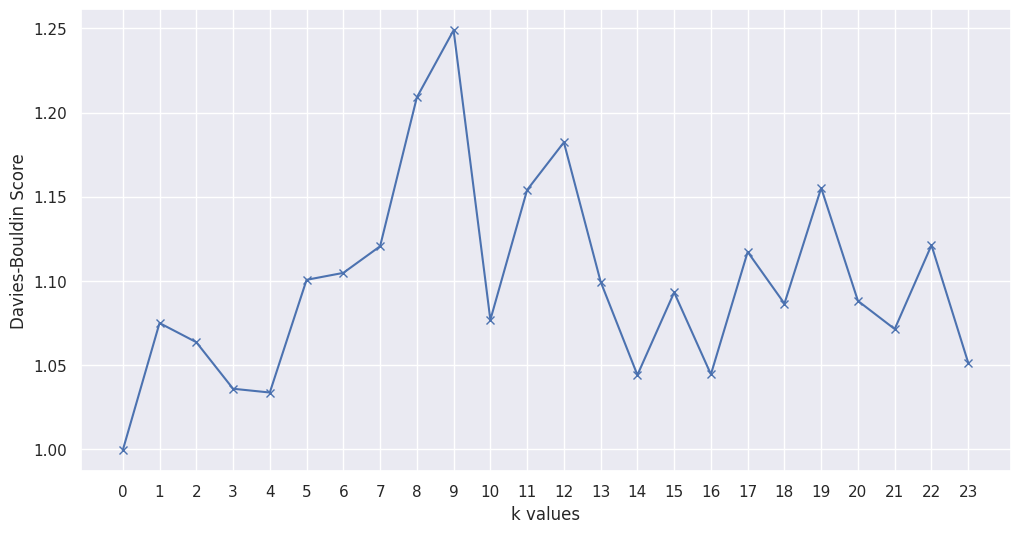

<Figure size 640x480 with 0 Axes>

In [5]:
# Sample data for plotting
k_values = range(0,24)
plt.figure(figsize=(12, 6))

# Plot Davies-Bouldin Score
plt.plot(k_values, DBL_values, 'bx-')
plt.xlabel('k values')
plt.ylabel('Davies-Bouldin Score')
plt.xticks(k_values)
plt.show()
plt.savefig('Time.png')